In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, auc, roc_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import scipy.sparse as sp
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from nltk.tokenize import WordPunctTokenizer
import spacy
import scipy.sparse as sp
import shap

- Импортируем все файлы
- Убираем название аниме
- Энкодим таргет
- Убираем дупликаты
- Убираем пропуски

In [ ]:
part_1 = pd.read_excel('dataset1.xlsx')
part_2 = pd.read_excel('dataset2.xlsx')
part_3 = pd.read_excel('dataset3.xlsx')
part_4 = pd.read_excel('dataset4.xlsx')
df = pd.concat([part_1, part_2, part_3, part_4]).copy()

In [ ]:
df.drop(columns='Anime', axis=1, inplace=True)
label_encoder = LabelEncoder()
norm_labels = label_encoder.fit_transform(df['Rate'].to_list())
df['class'] = norm_labels
df.drop(columns='Rate', axis=1, inplace=True)
df = df.reset_index().drop(columns='index')
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

0 - нейтральный, 1 - негативный, 2 - положительный

Проверим на дисбаланс классов

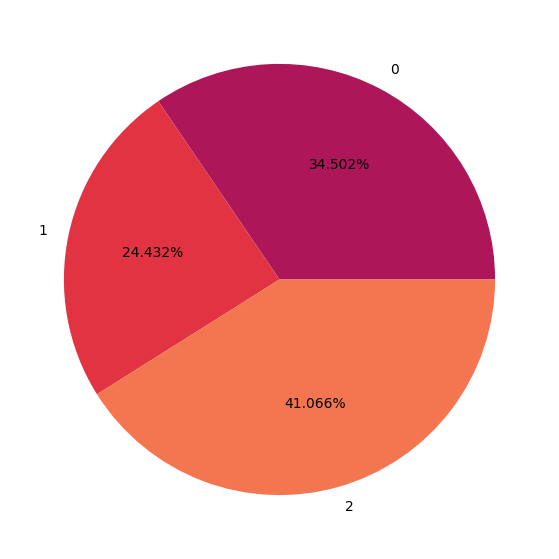

In [ ]:
plot_disbalance = pd.DataFrame(df['class'].value_counts(normalize=True).mul(100).sort_index())
fig = plt.figure(figsize=(10, 7))
colors = sns.color_palette('rocket')[2:5]
plt.pie(plot_disbalance['proportion'], labels=plot_disbalance.index, colors=colors, autopct='%.3f%%')
plt.show()

Хочу найти все варицации xd, привести их к одному формату и добавить кол-во xd как фичу

In [ ]:
def normalize_xd(text):
    pattern = re.compile(r'[xX]+[dD]+')
    return pattern.sub('xd', text)

df['Text'] = df['Text'].apply(normalize_xd)
df['xd'] = df['Text'].apply(lambda x: x.count('xd'))

Убираем ссылки

In [ ]:
def remove_links(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+|example\.\S+|vk\.\S+')
    return url_pattern.sub('', text)
df['Text'] = df['Text'].apply(remove_links)

Первая очевидная фича - длина отзыва

In [ ]:
df['text_length'] = df['Text'].apply(lambda x: len(x))

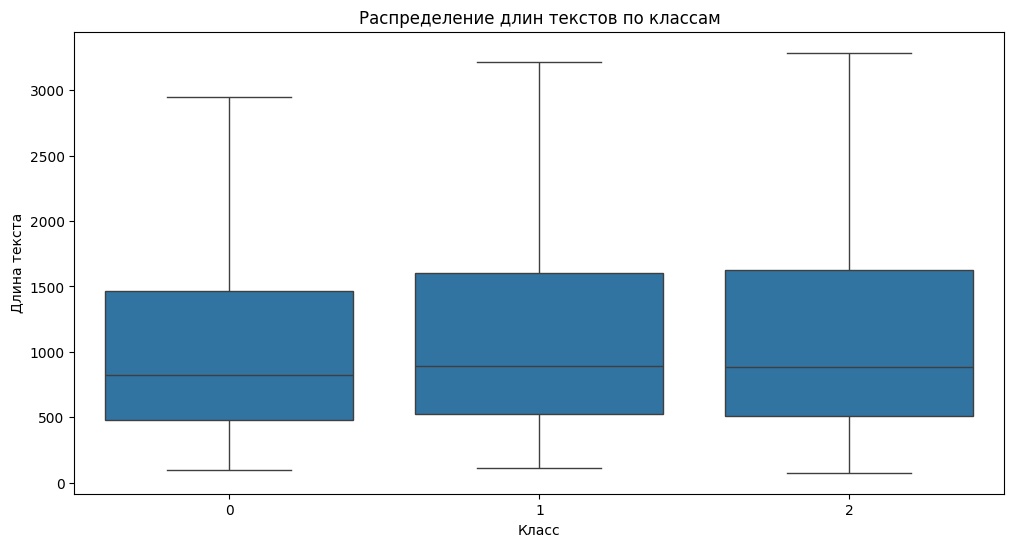

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='text_length', data=df, showfliers=False)
plt.title('Распределение длин текстов по классам')
plt.xlabel('Класс')
plt.ylabel('Длина текста')
plt.show()

In [ ]:
pd.concat([df[df['class'] == 0]['text_length'].describe(), df[df['class'] == 1]['text_length'].describe(), df[df['class'] == 2]['text_length'].describe()], axis=1)

,text_length,text_length,text_length
count,25247.000000,17878.000000,30050.000000
mean,1218.100329,1337.362736,1349.927354
std,1283.703081,1444.873502,1461.121441
min,99.000000,109.000000,75.000000
25%,477.000000,523.000000,512.000000
50%,825.000000,890.000000,882.000000
75%,1465.000000,1600.000000,1622.000000
max,32767.000000,32767.000000,32767.000000


In [ ]:
fliers = {0: df[df['class'] == 0]['text_length'].quantile(0.75), 1: df[df['class'] == 1]['text_length'].quantile(0.75), 2: df[df['class'] == 2]['text_length'].quantile(0.75)}
out_fliers = {0: df[(df['class'] == 0) & (df['text_length'] > fliers[0])].shape[0], 1: df[(df['class'] == 1) & (df['text_length'] > fliers[1])].shape[0] , 2: df[(df['class'] == 2) & (df['text_length'] > fliers[2])].shape[0]}
print('Кол-во выбросов для класса 0: ', out_fliers[0])
print('Кол-во выбросов для класса 1: ', out_fliers[1])
print('Кол-во выбросов для класса 2: ', out_fliers[2])

df['quant075'] = df['class'].apply(lambda x: fliers[x])
df['outlier'] = (df['text_length'] > df['quant075']).astype(str)
df.drop(columns='quant075', axis=1, inplace=True)
df.drop(columns='outlier', axis=1, inplace=True)

Кол-во выбросов для класса 0:  6310
Кол-во выбросов для класса 1:  4466
Кол-во выбросов для класса 2:  7512


In [ ]:
df['num_exclam'] = df['Text'].apply(lambda x: x.count('!'))
excl = {0: df[(df['class'] == 0) & (df['num_exclam'] > 0)].shape[0], 1: df[(df['class'] == 1) & (df['num_exclam'] > 0)].shape[0], 2: df[(df['class'] == 2) & (df['num_exclam'] > 0)].shape[0]}
print('Кол-во отзывов с воскл знаками класса 0: ', excl[0])
print('Кол-во отзывов с воскл знаками класса 1: ', excl[1])
print('Кол-во отзывов с воскл знаками класса 2: ', excl[2])

Кол-во отзывов с воскл знаками класса 0:  6576
Кол-во отзывов с воскл знаками класса 1:  4796
Кол-во отзывов с воскл знаками класса 2:  9442


Убираем даты, очень большие числа + обрабатываем случай, когда пользователь говорит о книгах и упоминаем страниц 88-101 и тп

In [ ]:
def remove_dates_and_large_numbers(text):
    pattern = re.compile(r'\b\d{4,}\b')
    text = pattern.sub('', text)
    pattern = re.compile(r'\b\d{2,}-\d{3,}\b')
    return pattern.sub('', text)

df['Text'] = df['Text'].apply(remove_dates_and_large_numbers)

Нужно извлечь рейтинг, который ставят любители аниме в своих отзывах. Так как они могу указать рейтинг разными способами: 9/10; 9 из 10;  9.5/10;  8.5-9.0/10 и тд, то пришлось повозиться

In [ ]:
def extract_rating(text):
    pattern = re.compile(r'\b(\d{1,2}(?:[.,]\d{1,2})?)\b(?:[-/]?\d*(?:[.,]?\d+)?\/?10| из 10)')
    match = pattern.search(text)
    if match:

        if float(match.group(1).replace(',', '.')) > 100:
            return 100
        else:
            return float(match.group(1).replace(',', '.'))
    return -1
df['rating'] = df['Text'].apply(extract_rating)

In [ ]:
pd.concat([df[(df['class'] == 0) & (df['rating'] >= 0)]['rating'].describe(), df[(df['class'] == 1) & (df['rating'] >= 0)]['rating'].describe(), df[(df['class'] == 2) & (df['rating'] >= 0)]['rating'].describe()], axis=1)

,rating,rating,rating
count,9596.000000,6952.000000,11532.000000
mean,7.660354,5.212476,8.926575
std,2.518212,2.509907,2.515396
min,0.000000,0.000000,0.000000
25%,7.000000,4.000000,8.000000
50%,8.000000,5.000000,9.000000
75%,8.500000,6.000000,10.000000
max,90.000000,70.000000,99.900000


In [ ]:
def idk_rating(x):
    if x == -1: return 'no_inf'
    elif x <= 6.25: return 'bad'
    elif x <= 8.25: return 'neutral'
    else: return 'good'

df['rating'] = df['rating'].apply(idk_rating)

In [ ]:
df

,Text,class,text_length,num_exclam,xd,rating
0,"после первой арки несколько разочаровался, ожи...",0,185,0,0,no_inf
1,"Концовка какая-то мутная, ничего не понял. Над...",2,148,0,0,no_inf
2,"Что тут сказать? Никакого сравнени я с Seed, х...",2,897,1,0,bad
3,Только что досмотрел и меня переполняют эмоции...,2,560,0,0,no_inf
4,"И правда не оторваться. Но, по-моему, то, что ...",2,311,1,0,no_inf
...,...,...,...,...,...,...
73211,Я просмотрел 82 серии Пожирателя звёзд (Swallo...,2,858,0,0,no_inf
73212,Я был сильно заинтригован аниме Поглощающая Зв...,2,931,0,0,no_inf
73213,докатились. после просмотра этого чуда я добав...,0,794,0,0,no_inf
73214,Вокруг этого произведения собралось достаточно...,2,2262,0,0,neutral


In [ ]:
from nltk.tokenize import WordPunctTokenizer
import spacy

nlp = spacy.load("ru_core_news_lg")
tokenizer = WordPunctTokenizer()

In [ ]:
def smart_cleaning(text):
    tokens = tokenizer.tokenize(text)
    we = ' '.join([i for i in tokens if i.isalpha()])
    doc = nlp(we)
    lemmas = ' '.join([token.lemma_ for token in doc])
    return lemmas

In [ ]:
df['cleaned_text'] = df['Text'].apply(smart_cleaning)

Идея: скорее всего именно прилагательные будут давать эмоциональный окрас. Давайте найдем все прилагательные и дадим им скор из модельки для сентимент анализа. Затем, если в отзыве есть прилагательные - то найдем сумму их скоров, если прилагательных нет - то дадим 0

In [ ]:
model_sent = pipeline("sentiment-analysis", "blanchefort/rubert-base-cased-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Пройдемся по всем словам, которые встречались хотя бы 5 раз и найдем все прилагательные

In [ ]:
token_counter = Counter()
for one_string in df['cleaned_text'].values:
    for token in one_string.split():
        token_counter[token] += 1

norm_words = [i for i,v in token_counter.items() if v > 4]

adjectives = {}
for i in tqdm(norm_words):
    if nlp(i)[0].pos_ == 'ADJ':
        adjectives[i] = token_counter[i]
adjectives = {k: v for k, v in sorted(adjectives.items(), key=lambda item: item[1], reverse=True)}

Тут получаю словарик {прилагательное1: скор1;  прилагательное2: скор2, ...}

In [ ]:
new_adj = {}
for i,v in tqdm(adjectives.items()):
    lab = model_sent(i)[0]['label']
    score = model_sent(i)[0]['score']
    if lab == 'NEGATIVE':
        new_adj[i] = -score
    elif lab == 'POSITIVE':
        new_adj[i] = score
    elif lab == 'NEUTRAL':
        new_adj[i] = 0

100%|██████████| 7290/7290 [20:57<00:00,  5.80it/s]


In [ ]:
def count_score(text):
    score = 0
    for i in text.split():
        if i in set_adjectives:
            score += new_adj[i]
    return score

set_adjectives = set(new_adj.keys())
df['score'] = df['cleaned_text'].apply(count_score)

Имеем такие файлики:
<br> - cleaned.csv - отчищенный текст
<br> - score.csv - наш подсчитанный скор
<br> - data1-4.csv - все остальные фичи

In [ ]:
df.iloc[:18000].to_csv('data1.csv')
df.iloc[18000:36000].to_csv('data2.csv')
df.iloc[36000:54000].to_csv('data3.csv')
df.iloc[54000:].to_csv('data4.csv')

df[['cleaned_text']].to_csv('cleaned.csv', index=False)

df[['score']].to_csv('score.csv')

In [ ]:
part_1 = pd.read_csv('data1.csv')
part_2 = pd.read_csv('data2.csv')
part_3 = pd.read_csv('data3.csv')
part_4 = pd.read_csv('data4.csv')
df = pd.concat([part_1, part_2, part_3, part_4]).reset_index()
df.drop(columns=['Unnamed: 0', 'index'], axis=1, inplace=True)

In [ ]:
df_plain = pd.read_csv('cleaned.csv')

In [ ]:
def delete_engl(text):
    text = re.sub(r'[a-zA-Z]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words and word.isalpha()])
    return text
nltk.download('stopwords')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_plain['cleaned_text'] = df_plain['cleaned_text'].apply(delete_engl)

In [ ]:
score = pd.read_csv('score.csv')

In [ ]:
df['Text'] = df_plain['cleaned_text'].apply(lambda x: x.lower())
df['score'] = score['score']

In [ ]:
df

,Text,class,text_length,num_exclam,xd,rating,score
0,первый арка несколько разочароваться ожидать б...,0,185,0,0,no_inf,0.000000
1,концовка мутный ничто понять надеяться второй ...,2,148,0,0,no_inf,-1.496759
2,сказать никакой сравнени пытаться подражать ба...,2,897,1,0,bad,2.505658
3,досмотреть переполнять эмоция шедевр затягиват...,2,560,0,0,no_inf,-0.133373
4,правда оторваться моему медузе серия езмъ плюс...,2,311,1,0,no_inf,0.979600
...,...,...,...,...,...,...,...
73170,просмотреть серия пожиратель звезда день мочь ...,2,858,0,0,no_inf,5.007128
73171,сильно заинтриговать аниме поглощать звезда де...,2,931,0,0,no_inf,4.221517
73172,докатиться просмотр это чудо добавить избрать ...,0,794,0,0,no_inf,1.929925
73173,вокруг это произведение собраться достаточный ...,2,2262,0,0,neutral,-3.645133


Слова которые встречались меньше 5 раз нам в целом неинтересны, так как они встречаются супер редко + после Tf-iDf будет 200.000 столбцов. Их я уберу и после векторизации будет +- 50.000 столбцов

In [ ]:
token_counter = Counter()
for one_string in df['Text'].values:
    for token in one_string.split():
        token_counter[token] += 1
nice_words = set([i for i,v in token_counter.items() if v > 4])

In [ ]:
def del_unique(text):
    return ' '.join([i for i in text.split() if i in nice_words])
df['Text'] = df['Text'].apply(del_unique)

Идея: я хочу добавить в качестве фичей флаг, есть ли в отзыве слово из списка important_words_qq, так как по моему мнению, они обладают наибольшим скором, который почти сразу позволит определить эмоц окрас отзыва

(Хотя на самом деле, в tf-idf это в каком-то роде учитывается)

In [ ]:
important_words_qq = ['потрясающе', 'обожаю', 'шедевр', 'отличный', 'бред', 'убогий', 'позор']
for word in tqdm(important_words_qq):
    pices = []
    for i,v in enumerate(df['Text'].values):
        if word in v:
            pices.append(1)
        else:
            pices.append(0)
    pices = pd.Series(pices, name=word)
    df[word] = pices

100%|██████████| 7/7 [00:00<00:00,  9.47it/s]


In [ ]:
df.rename(columns={'потрясающе': 'fabulous', 'обожаю': 'adore', 'шедевр': 'masterpiece', 'отличный': 'excellent', 'бред': 'delusion', 'убогий': 'miserable', 'позор': 'shame'}, inplace=True)

In [ ]:
df_ = pd.get_dummies(df.drop(columns='Text'), dtype=int)

In [ ]:
df_

,class,text_length,num_exclam,xd,score,fabulous,adore,masterpiece,excellent,delusion,miserable,shame,rating_bad,rating_good,rating_neutral,rating_no_inf
0,0,185,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,1
1,2,148,0,0,-1.496759,0,0,0,0,0,0,0,0,0,0,1
2,2,897,1,0,2.505658,0,0,0,0,0,0,0,1,0,0,0
3,2,560,0,0,-0.133373,0,0,1,0,0,0,0,0,0,0,1
4,2,311,1,0,0.979600,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73170,2,858,0,0,5.007128,0,0,0,1,0,0,0,0,0,0,1
73171,2,931,0,0,4.221517,1,0,0,1,0,0,0,0,0,0,1
73172,0,794,0,0,1.929925,0,0,0,0,0,0,0,0,0,0,1
73173,2,2262,0,0,-3.645133,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df['Text'])

In [ ]:
X = sp.hstack((X_text, df_.drop(columns=['class'], axis=1)))
y = df['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=10)
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.16, shuffle=True, random_state=10)

## LGBM

In [ ]:
lgbm = LGBMClassifier(objective='multiclass', is_unbalance=True, random_state=10)
eval_set = [(X_val, y_val)]
lgbm.fit(X_train_, y_train_, eval_metric='multi_logloss', eval_set=eval_set)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 28.115312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794445
[LightGBM] [Info] Number of data points in the train set: 49173, number of used features: 15331
[LightGBM] [Info] Start training from score -1.062896
[LightGBM] [Info] Start training from score -1.417547
[LightGBM] [Info] Start training from score -0.886153


LGBMClassifier(is_unbalance=True, objective='multiclass', random_state=10)

In [ ]:
y_pred = lgbm.predict(X_test)

In [ ]:
def get_metrics_multiclass(y_test, y_pred, name):
    """
    y_test - метки класса без бинаризации
    name - название модели/подхода
    """
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['Precision_micro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='micro')
    df_metrics['Precision_macro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='macro')
    df_metrics['Recall_micro'] = recall_score(y_test, y_pred, average='micro')
    df_metrics['Recall_macro'] = recall_score(y_test, y_pred, average='macro')
    df_metrics['F1_micro'] = f1_score(y_test, y_pred, average='micro')
    df_metrics['F1_macro'] = f1_score(y_test, y_pred, average='macro')
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    return df_metrics

In [ ]:
pd.concat([get_metrics_multiclass(y_train, lgbm.predict(X_train), 'train'), get_metrics_multiclass(y_test, y_pred, 'test')])

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Accuracy
0,train,0.688435,0.690726,0.688435,0.682183,0.688435,0.684292,0.688435
0,test,0.603348,0.601823,0.603348,0.596923,0.603348,0.597011,0.603348


In [ ]:
importances = lgbm.feature_importances_
feature_names = vectorizer.get_feature_names_out().tolist() + df_.drop(columns=['class']).columns.tolist()

In [ ]:
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
trimmed_importance = importance_df.iloc[:50]

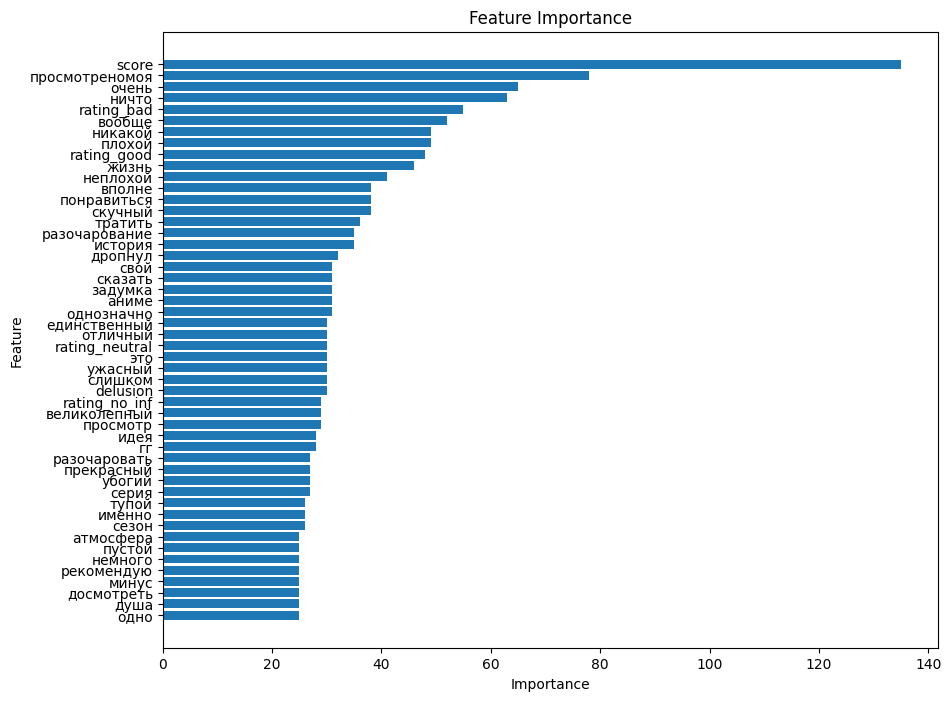

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(trimmed_importance['Feature'], trimmed_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import lightgbm as lgb

In [ ]:
def visualize_lgb_tree(model, tree_index, feature_names):
    tree_str = model.booster_.dump_model()['tree_info'][tree_index]['tree_structure']
    graph = lgb.create_tree_digraph(model.booster_, tree_index=tree_index, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
    return graph

lgb_graph = visualize_lgb_tree(lgbm, tree_index=5, feature_names=vectorizer.get_feature_names_out())
lgb_graph.render("lgbm_tree_fifth")

'lgbm_tree_fifth.pdf'

5ое дерево бустинга: https://drive.google.com/file/d/1H4ONIN376S0XoKbrKOCfx42RjSyFIXUS/view?usp=sharing

In [ ]:
explainer = shap.TreeExplainer(lgbm)

# Попытка вычисления SHAP-значений для первых 10 строк тестовых данных
try:
    shap_values = explainer.shap_values(X_test.toarray()[:1750])
    print("SHAP values computed successfully for first 1750 rows")
except Exception as e:
    print(f"Error computing SHAP values: {e}")

SHAP values computed successfully for first 1750 rows


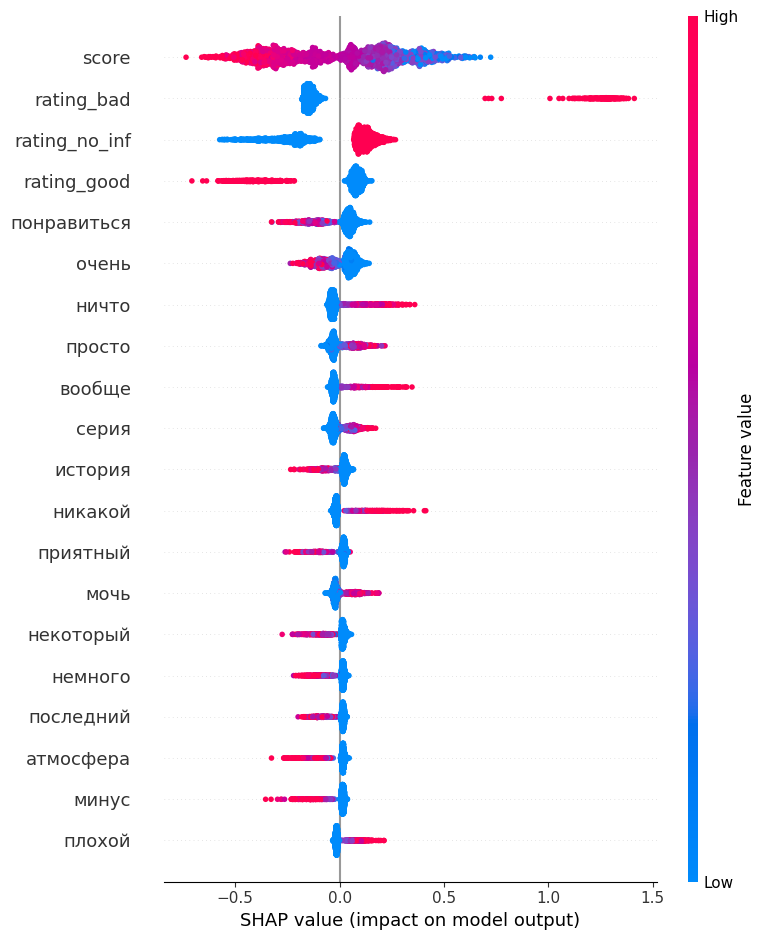

In [ ]:
shap_values_class_1 = shap_values[:, :, 1]
feature_importance_1 = np.abs(shap_values_class_1).mean(axis=0)
top_indices = np.argsort(feature_importance_1)[-50:]
shap_values_top_50 = shap_values_class_1[:, top_indices]
feature_names_shap = (np.array(feature_names)[top_indices]).tolist()
shap_values_df = pd.DataFrame(shap_values_top_50, columns=feature_names_shap)
shap.summary_plot(shap_values_df.values, features=X_test.toarray()[:1750][:, top_indices], feature_names=feature_names_shap)

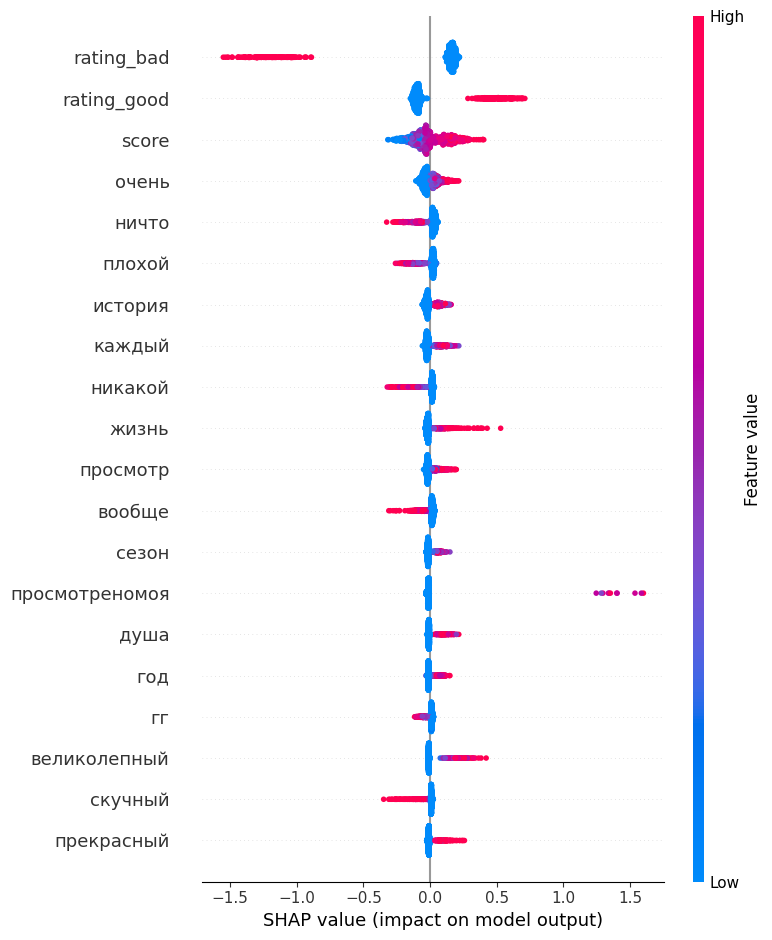

In [ ]:
shap_values_class_2 = shap_values[:, :, 2]
feature_importance_2 = np.abs(shap_values_class_2).mean(axis=0)
top_indices = np.argsort(feature_importance_2)[-50:]
shap_values_top_50 = shap_values_class_2[:, top_indices]
feature_names_shap = (np.array(feature_names)[top_indices]).tolist()
shap_values_df = pd.DataFrame(shap_values_top_50, columns=feature_names_shap)
shap.summary_plot(shap_values_df.values, features=X_test.toarray()[:1750][:, top_indices], feature_names=feature_names_shap)

## Random Forest

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=10, min_samples_leaf=10, max_depth=35)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=35,
                       min_samples_leaf=10, random_state=10)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
pd.concat([get_metrics_multiclass(y_train, rf.predict(X_train), 'train'), get_metrics_multiclass(y_test, rf.predict(X_test), 'test')])

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Accuracy
0,train,0.701213,0.694204,0.701213,0.710364,0.701213,0.696384,0.701213
0,test,0.592415,0.579724,0.592415,0.601523,0.592415,0.582316,0.592415


In [ ]:
importances_rf = rf.feature_importances_
feature_names_rf = vectorizer.get_feature_names_out().tolist() + df_.drop(columns=['class']).columns.tolist()

In [ ]:
importance_df_rf = pd.DataFrame({'Feature': feature_names_rf, 'Importance': importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)
trimmed_importance_rf = importance_df_rf.iloc[:50]

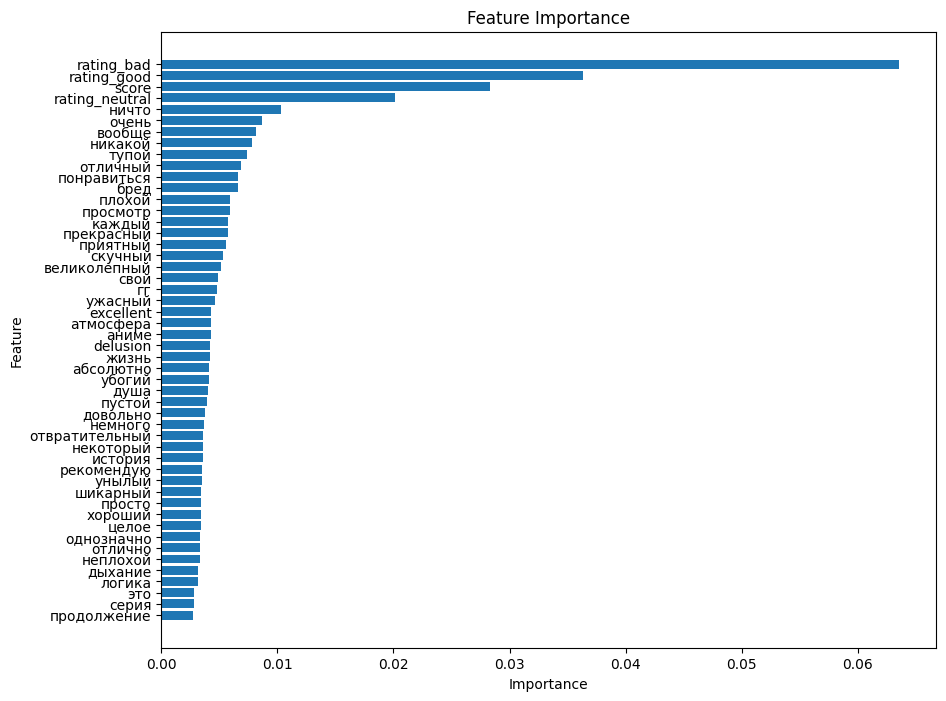

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(trimmed_importance_rf['Feature'], trimmed_importance_rf['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

In [ ]:
estimator = rf.estimators_[5]

# Экспортируем дерево в формат DOT
dot_data = export_graphviz(estimator, out_file=None,  feature_names=feature_names,
                           class_names=True, filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("random_forest_tree")

'random_forest_tree.pdf'

Вот кусочек 5го дерева - https://drive.google.com/file/d/1ywfWfrFgpSFFQXs2SLflut9nhu1CvZ3f/view?usp=sharing

Вот полное 5е дерево :) https://drive.google.com/file/d/1erkVSuOe-PgtVduZMpHr4mLlgrYLhMe-/view?usp=sharing

In [ ]:
explainer = shap.TreeExplainer(rf)

# Попытка вычисления SHAP-значений для первых 10 строк тестовых данных
try:
    shap_values = explainer.shap_values(X_test.toarray()[:1750])
    print("SHAP values computed successfully for first 1750 rows")
except Exception as e:
    print(f"Error computing SHAP values: {e}")

SHAP values computed successfully for first 1750 rows


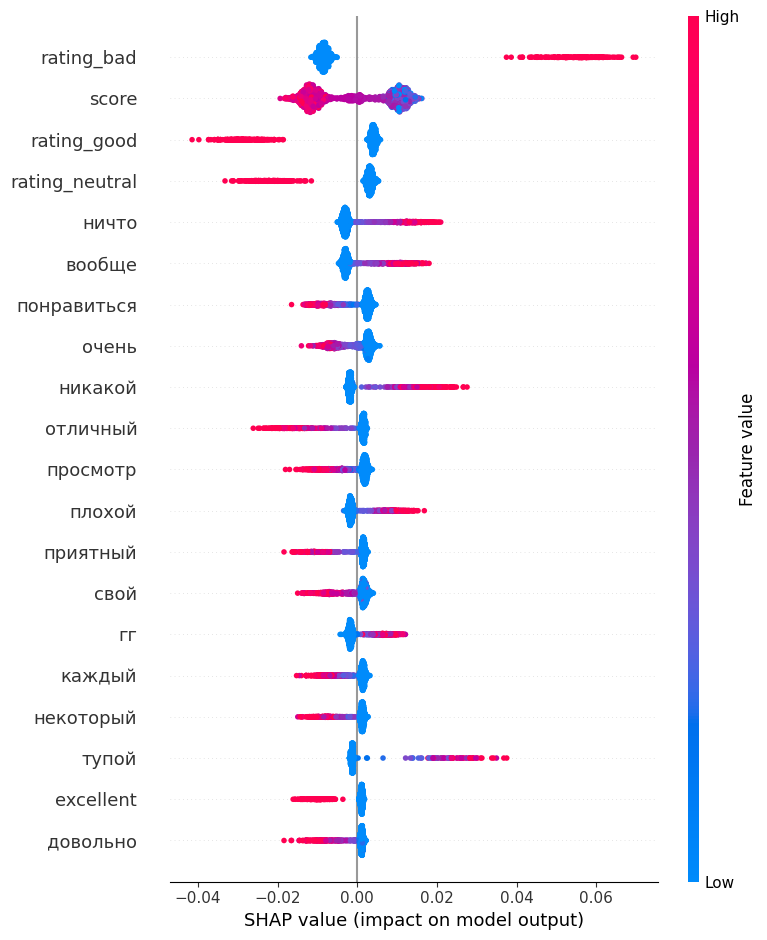

In [ ]:
shap_values_class_1 = shap_values[:, :, 1]
feature_importance_1 = np.abs(shap_values_class_1).mean(axis=0)
top_indices = np.argsort(feature_importance_1)[-50:]
shap_values_top_50 = shap_values_class_1[:, top_indices]
feature_names_shap = (np.array(feature_names)[top_indices]).tolist()
shap_values_df = pd.DataFrame(shap_values_top_50, columns=feature_names_shap)
shap.summary_plot(shap_values_df.values, features=X_test.toarray()[:1750][:, top_indices], feature_names=feature_names_shap)

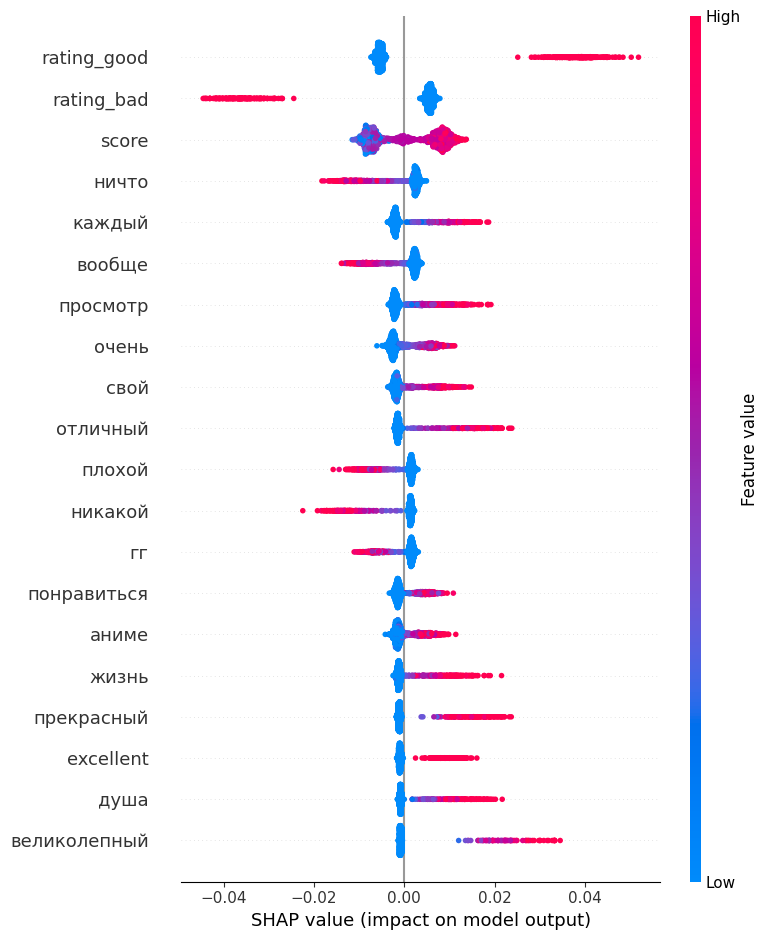

In [ ]:
shap_values_class_2 = shap_values[:, :, 2]
feature_importance_2 = np.abs(shap_values_class_2).mean(axis=0)
top_indices = np.argsort(feature_importance_2)[-50:]
shap_values_top_50 = shap_values_class_2[:, top_indices]
feature_names_shap = (np.array(feature_names)[top_indices]).tolist()
shap_values_df = pd.DataFrame(shap_values_top_50, columns=feature_names_shap)
shap.summary_plot(shap_values_df.values, features=X_test.toarray()[:1750][:, top_indices], feature_names=feature_names_shap)

На самом деле, по моим прогнозам, случайный лес должен был быть намного хуже чем любой градиентный бустинг, так как для бустинга у нас было достаточно данных и в целом это более сильный алгоритм.
<br>
<br> Но случайный лест показал результат в 59.2%, когда LGMB показал 60.33%. Поэтому вполне разумный выбор для этой задачи - бустинг.

P.S. Случайный лес тут дико переобучается. Его бейзлайн идеально выучивает тренировочную выборку, так что пришлось чуть подкрутить макс глубину

## LDA

In [ ]:
indexes_neutral = df_bertopic[df_bertopic['class'] == 0]['Text'].index
indexes_negative = df_bertopic[df_bertopic['class'] == 1]['Text'].index
indexes_positive = df_bertopic[df_bertopic['class'] == 2]['Text'].index
doc_0, emb_0 = df_bertopic[df_bertopic['class'] == 0]['Text'].to_list(), X_text[indexes_neutral]
doc_1, emb_1 = df_bertopic[df_bertopic['class'] == 1]['Text'].to_list(), X_text[indexes_negative]
doc_2, emb_2 = df_bertopic[df_bertopic['class'] == 2]['Text'].to_list(), X_text[indexes_positive]

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize
nlp = spacy.load("ru_core_news_lg")

In [ ]:
norm_emb1 = normalize(emb_1, norm="l1", axis=1)
lda_model1 = LatentDirichletAllocation(n_components=35, random_state=10)
lda_model1.fit(norm_emb1)

LatentDirichletAllocation(n_components=35, random_state=10)

In [ ]:
def print_topics1(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Тема #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1] if nlp(feature_names[i])[0].pos_ != 'PROPN' and nlp(feature_names[i])[0].ent_type_ not in ['PER', 'ORG'] and feature_names[i] not in set(stop_words + ['это', 'Это']) ])
        print(message)

n_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
print_topics1(lda_model1, tf_feature_names, n_top_words)

# Присвоение тем документам
doc_topic_dist = lda_model1.transform(norm_emb1)
document_topics = doc_topic_dist.argmax(axis=1)

# Создание DataFrame для удобного просмотра результатов
df_lda_0 = pd.DataFrame({'Document': doc_1, 'Topic': document_topics})

Тема #0: засыпать поиграть выкидыш доспехах финт посидеть передышка анимерисовка взахлёб неискушённый
Тема #1: анимешка неинтересно передумать гнать досмотрела выжать рил инами продолжительность волшебство
Тема #2: ммо освежить мучение притензий дар приблизительно светить ванпанчмен
Тема #3: аниме серия весь сюжет персонаж просто смотреть мочь сезон
Тема #4: причудам косить гон акира целостность комент чизуру проклятый
Тема #5: начиналось кусочек футбол кибер тормоз хранитель стабильно боевку лечь накидать
Тема #6: танец потеряться чтиво весело слюна адрес бдсм пиар транспорт
Тема #7: ценитель попсовый нагаторо кхе простецкий волчица
Тема #8: беспощадный средняк смысла наофуми переоцененный неочень мобов скучноватое суперский
Тема #9: шлюха анкорда давным говнеца гольф цитрус обломать враждовать
Тема #10: рекомендоваться уснуть вкусный двоякий насрать задница заняться педофилия омерзительный
Тема #11: хотару маловато конвейер пубертатный ориентация давольно лаки юма овах
Тема #12: инде

In [ ]:
norm_emb2 = normalize(emb_2, norm="l1", axis=1)
lda_model2 = LatentDirichletAllocation(n_components=35, random_state=10)
lda_model2.fit(norm_emb2)

LatentDirichletAllocation(n_components=35, random_state=10)

In [ ]:
def print_topics2(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Тема #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1] if nlp(feature_names[i])[0].pos_ != 'PROPN' and nlp(feature_names[i])[0].ent_type_ not in ['PER', 'ORG'] and feature_names[i] not in set(stop_words + ['это', 'Это']) ])
        print(message)

n_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
print_topics2(lda_model2, tf_feature_names, n_top_words)

# Присвоение тем документам
doc_topic_dist = lda_model2.transform(norm_emb2)
document_topics = doc_topic_dist.argmax(axis=1)

# Создание DataFrame для удобного просмотра результатов
df_lda_0 = pd.DataFrame({'Document': doc_2, 'Topic': document_topics})

Тема #0: досуг натянутый римуру возбуждать папаша сиэля нервно раскрыли шинигами порыдать
Тема #1: тор угодить граф полчаса предшественник негативно преувеличивать коносубы просмотрев завернуть
Тема #2: формула психологически ересь наруми ание засунуть шутейки
Тема #3: аниме очень весь хороший персонаж сезон сюжет серия смотреть
Тема #4: одобрять даа нраву кемпинг повар анимке гад эдинг
Тема #5: сененов молиться завлекать веселиться карасуно воспитать ржачно совать прикосновение
Тема #6: чаровать мрачноватый рэцуко ложный айдол неловкость подтянуть иссекай ржака
Тема #7: джаз училка чардизайн страничка компьютерный сезона длина многосерийный дата намешать
Тема #8: ки холо восьмой торговля скомканным маги принуждённо
Тема #9: сакамото слащавый перемотка невинность заметка хы месиво
Тема #10: берсерка уставать боевка бабочка дерево заезженный юкино вялый очаровать сдать
Тема #11: кланнада торговец лабиринт киото тащусь полюбившимися кага кавайности сейрин
Тема #12: спешлы романтично помн

Если сравнивать LDA с feature importance из бустинга, то тут сложно сказать, насколько близки результаты, так как мы не знаем какой кластер больше влияет на таргет. Но LDA отработал +- нормально, из приведенных класетров можно понять, нейтральный, отрицательный или положительный это класс.